# 06 - MODELO SVM (SUPPORT VECTOR MACHINES)

Conjunto de métodos de aprendizaje supervisado que analizan datos para su clasificación y análisis de regresión.

Funcionan encontrando el hiperplano óptimo que separa las diferentes clases en el espacio de características.

El objetivo principal de las SVM es maximizar el margen entre los puntos de datos más cercanos de diferentes clases, conocidos como vectores de soporte.

## Librerías

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,
    balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Cargar Datos Preprocesados

In [6]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

print("Dimensiones")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"\nFraude en train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"Fraude en test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.2f}%)")

Dimensiones
X_train: (16000, 13)
X_test: (4000, 13)
y_train: (16000,)
y_test: (4000,)

Fraude en train: 160 (1.00%)
Fraude en test: 40 (1.00%)


## Balanceo de Clases con SMOTE


In [7]:
print("Distribución en Train antes de SMOTE:")
print(y_train.value_counts())

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar resample solo al conjunto de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribución en Train después de SMOTE:")
print(y_train_balanced.value_counts())

# Reemplazar las variables de entrenamiento
X_train = X_train_balanced
y_train = y_train_balanced

Distribución en Train antes de SMOTE:
isFraud
0    15840
1      160
Name: count, dtype: int64

Distribución en Train después de SMOTE:
isFraud
0    15840
1    15840
Name: count, dtype: int64


## Configuración Experimental - Malla de Hiperparámetros

In [8]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['auto', 'scale', 0.0001, 0.001],  # Valores válidos para gamma
    'class_weight': [None, 'balanced']
}

print("Malla de Hiperparámetros para SVM:")
print(f"C: {param_grid['C']}")
print(f"kernel: {param_grid['kernel']}")
print(f"gamma: {param_grid['gamma']}")
print(f"class_weight: {param_grid['class_weight']}")
print(f"\nTotal de combinaciones: {len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) * len(param_grid['class_weight'])}")

Malla de Hiperparámetros para SVM:
C: [0.1, 1, 10, 100]
kernel: ['rbf', 'linear']
gamma: ['auto', 'scale', 0.0001, 0.001]
class_weight: [None, 'balanced']

Total de combinaciones: 64


## Metodología de Validación

In [9]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'balanced_accuracy': 'balanced_accuracy'
}

svc = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    svc,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV configurado con:")
print(f"- Validación cruzada: 5-fold estratificada")
print(f"- Métrica de selección: Balanced Accuracy")
print(f"- Otras métricas evaluadas: {list(scoring.keys())}")

GridSearchCV configurado con:
- Validación cruzada: 5-fold estratificada
- Métrica de selección: Balanced Accuracy
- Otras métricas evaluadas: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'balanced_accuracy']


## Búsqueda de Hiperparámetros

In [10]:
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Balanced Accuracy (CV): {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores parámetros: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor Balanced Accuracy (CV): 0.9933


In [11]:
# Examinar el mejor modelo

# Mejor puntuación obtenida durante GridSearchCV
print('Mejor puntuación de GridSearch CV: {:.4f}\n\n'.format(grid_search.best_score_))
# Imprimir los parámetros que arrojan los mejores resultados
print('Parámetros que arrojan los mejores resultados:','\n\n', (grid_search.best_params_))
# Imprimir el estimador seleccionado por GridSearch
print('\n\nEstimador seleccionado por la búsqueda:','\n\n', (grid_search.best_estimator_))

Mejor puntuación de GridSearch CV: 0.9933


Parámetros que arrojan los mejores resultados: 

 {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


Estimador seleccionado por la búsqueda: 

 SVC(C=100, probability=True, random_state=42)


## Resultados de Validación Cruzada

In [12]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_balanced_accuracy')

top_10 = cv_results[[
    'param_C', 'param_kernel', 'param_gamma', 'param_class_weight',
    'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
    'mean_test_f1', 'mean_test_recall', 'mean_test_precision'
]].head(10)

print("\nmejores 10 configuraciones (validación cruzada):")
print(top_10.to_string())


mejores 10 configuraciones (validación cruzada):
    param_C param_kernel param_gamma param_class_weight  mean_test_balanced_accuracy  std_test_balanced_accuracy  mean_test_f1  mean_test_recall  mean_test_precision
50    100.0          rbf       scale               None                     0.993277                    0.000744      0.993322          0.999937             0.986794
58    100.0          rbf       scale           balanced                     0.993277                    0.000744      0.993322          0.999937             0.986794
56    100.0          rbf        auto           balanced                     0.991856                    0.000945      0.991922          0.999937             0.984036
48    100.0          rbf        auto               None                     0.991856                    0.000945      0.991922          0.999937             0.984036
42     10.0          rbf       scale           balanced                     0.984659                    0.001704      0.

## Evaluación en Entrenamiento, Validación y Test del mejor modelo encontrado

In [14]:
best_model = grid_search.best_estimator_

# Predicciones en Train
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Predicciones en Test
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Predicciones con validación cruzada (para intervalo de confianza)
y_val_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
y_val_pred_proba = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

## Cálculo de Métricas con Intervalos de Confianza

In [16]:
def compute_metrics_with_ci(y_true, y_pred, y_proba, set_name=''):
    metrics = {}

    # Balanced Accuracy
    ba = balanced_accuracy_score(y_true, y_pred)

    # Precision
    prec = precision_score(y_true, y_pred, zero_division=0)

    # Recall
    rec = recall_score(y_true, y_pred, zero_division=0)

    # F1-Score
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_proba)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Intervalo de confianza (95%) usando bootstrap
    n_bootstrap = 1000
    ba_bootstrap = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        ba_bootstrap.append(balanced_accuracy_score(y_true.iloc[idx], y_pred[idx]))

    ba_ci = np.percentile(ba_bootstrap, [2.5, 97.5])

    return {
        'Balanced Accuracy': f"{ba:.4f} [{ba_ci[0]:.4f}, {ba_ci[1]:.4f}]",
        'Precision': f"{prec:.4f}",
        'Recall': f"{rec:.4f}",
        'F1-Score': f"{f1:.4f}",
        'AUC-ROC': f"{auc_roc:.4f}",
        'Accuracy': f"{acc:.4f}"
    }

metrics_train = compute_metrics_with_ci(y_train, y_train_pred, y_train_pred_proba, 'Train')
metrics_val = compute_metrics_with_ci(y_train, y_val_pred, y_val_pred_proba, 'Validación')
metrics_test = compute_metrics_with_ci(y_test, y_test_pred, y_test_pred_proba, 'Test')

results_df = pd.DataFrame({
    'Train': metrics_train,
    'Validación (CV)': metrics_val,
    'Test': metrics_test
})

print("\n=== RESULTADOS DEL MODELO SVM ===")
print(results_df.to_string())


=== RESULTADOS DEL MODELO SVM ===
                                     Train          Validación (CV)                     Test
Balanced Accuracy  0.9953 [0.9945, 0.9960]  0.9933 [0.9924, 0.9941]  0.8556 [0.7786, 0.9232]
Precision                           0.9906                   0.9868                   0.3452
Recall                              1.0000                   0.9999                   0.7250
F1-Score                            0.9953                   0.9933                   0.4677
AUC-ROC                             0.9996                   0.9994                   0.9475
Accuracy                            0.9953                   0.9933                   0.9835


## Matriz de Confusión

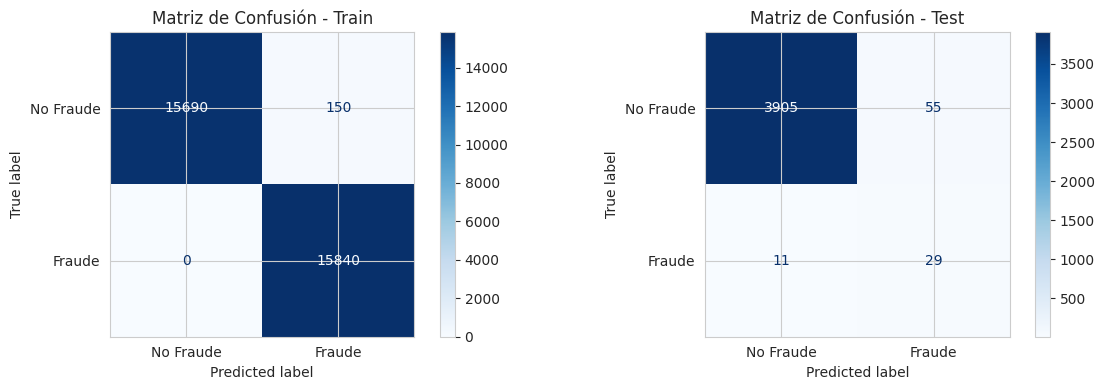

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=['No Fraude', 'Fraude']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Matriz de Confusión - Train')

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=['No Fraude', 'Fraude']).plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Matriz de Confusión - Test')

plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Curva ROC

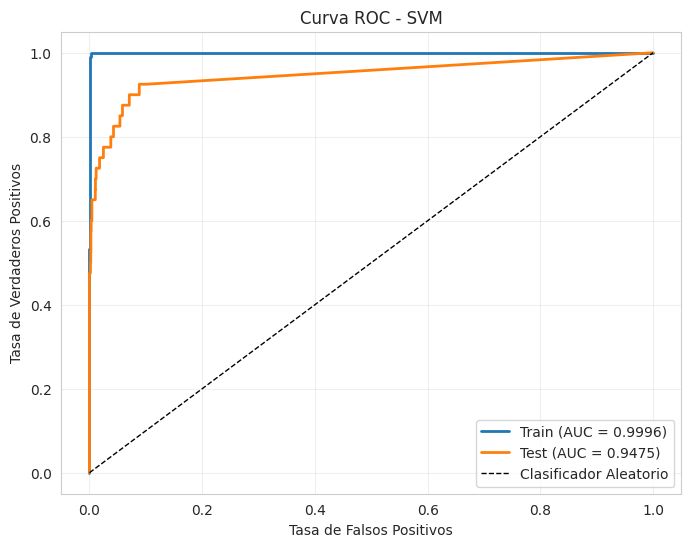

In [18]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('svm_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## Efecto de Hiperparámetros

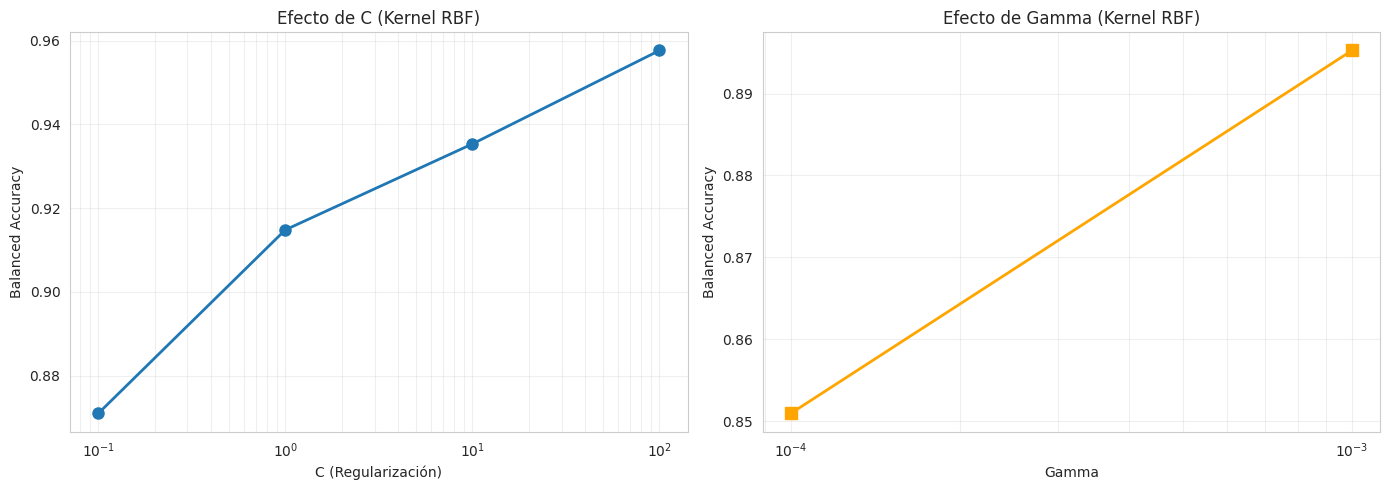

In [19]:
# Análisis del efecto de C y Gamma
# Filtramos solo para el kernel 'rbf' que es el que usa gamma
cv_results_rbf = cv_results[cv_results['param_kernel'] == 'rbf']

if not cv_results_rbf.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Efecto de C
    C_vals = cv_results_rbf['param_C'].unique()
    # Convertimos a float por si acaso son objetos
    C_vals = [float(x) for x in C_vals]
    C_vals.sort()

    means_C = []
    for c in C_vals:
        mask = cv_results_rbf['param_C'] == c
        if mask.any():
            means_C.append(cv_results_rbf[mask]['mean_test_balanced_accuracy'].mean())
        else:
            means_C.append(np.nan)

    axes[0].plot(C_vals, means_C, marker='o', linewidth=2, markersize=8)
    axes[0].set_xscale('log')  # Escala logarítmica para C
    axes[0].set_xlabel('C (Regularización)')
    axes[0].set_ylabel('Balanced Accuracy')
    axes[0].set_title('Efecto de C (Kernel RBF)')
    axes[0].grid(alpha=0.3, which="both")

    # Efecto de Gamma (solo valores numéricos, excluimos 'auto' y 'scale' para la gráfica)
    # Si gamma tiene strings, filtramos solo los numéricos para graficar
    gamma_vals = []
    means_gamma = []

    for g in cv_results_rbf['param_gamma'].unique():
        if isinstance(g, (int, float)):
            gamma_vals.append(g)
            mask = cv_results_rbf['param_gamma'] == g
            means_gamma.append(cv_results_rbf[mask]['mean_test_balanced_accuracy'].mean())

    if gamma_vals:
        # Ordenar para que la línea salga bien
        sorted_pairs = sorted(zip(gamma_vals, means_gamma))
        gamma_vals = [p[0] for p in sorted_pairs]
        means_gamma = [p[1] for p in sorted_pairs]

        axes[1].plot(gamma_vals, means_gamma, marker='s', linewidth=2, markersize=8, color='orange')
        axes[1].set_xscale('log')  # Escala logarítmica para Gamma
        axes[1].set_xlabel('Gamma')
        axes[1].set_ylabel('Balanced Accuracy')
        axes[1].set_title('Efecto de Gamma (Kernel RBF)')
        axes[1].grid(alpha=0.3, which="both")
    else:
        axes[1].text(0.5, 0.5, 'No hay valores numéricos de Gamma para graficar',
                     ha='center', va='center')

    plt.tight_layout()
    plt.savefig('svm_hyperparameter_effect.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No hay resultados para kernel RBF para graficar.")
